In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from mlxtend.frequent_patterns import apriori, association_rules

# Load data with specified paths
player_sessions = pd.read_csv(r"C:\Users\s29sh\Downloads\player_sessions.csv", encoding='ISO-8859-1')
muscle_imbalance = pd.read_csv(r"C:\Users\s29sh\Downloads\muscle_imbalance_data.csv", encoding='ISO-8859-1')
injury_history = pd.read_csv(r"C:\Users\s29sh\Downloads\injury_history.csv", encoding='ISO-8859-1')

# Merge dataframes on 'Player.ID'
data = pd.merge(injury_history, player_sessions, on='Player.ID', how='inner')
data = pd.merge(data, muscle_imbalance, on='Player.ID', how='inner')

print(data.head())
print(data.columns)



   Player.ID           Name_x  Group.Id_x    Injury Type   Body Part   Side  \
0        101  Jordan Matthews         201  Muscle Strain  Quadriceps  Right   
1        101  Jordan Matthews         201  Muscle Strain  Quadriceps  Right   
2        101  Jordan Matthews         201  Muscle Strain  Quadriceps  Right   
3        101  Jordan Matthews         201  Muscle Strain  Quadriceps  Right   
4        101  Jordan Matthews         201  Muscle Strain  Quadriceps  Right   

  Injury Date Severity  Recovery Time (days)  \
0   12/5/2023  Grade 2                    51   
1   12/5/2023  Grade 2                    51   
2   12/5/2023  Grade 2                    51   
3   12/5/2023  Grade 2                    51   
4   12/5/2023  Grade 2                    51   

                                    Additional Notes  ... Exertions  \
0  Grade 2 quadriceps strain with partial tearing...  ...       132   
1  Grade 2 quadriceps strain with partial tearing...  ...       132   
2  Grade 2 quadriceps s

In [16]:
# Data Cleaning
# Drop columns with a large number of missing values
data = data.dropna(axis=1, thresh=len(data)*0.5)  # Drops columns with more than 50% missing values

# Fill remaining missing values with column mean for numeric and mode for categorical
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        data[col].fillna(data[col].mean(), inplace=True)

# Encoding categorical variables
label_encoder = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])



C:\Users\s29sh\AppData\Local\Temp\ipykernel_44232\3372151621.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
C:\Users\s29sh\AppData\Local\Temp\ipykernel_44232\3372151621.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

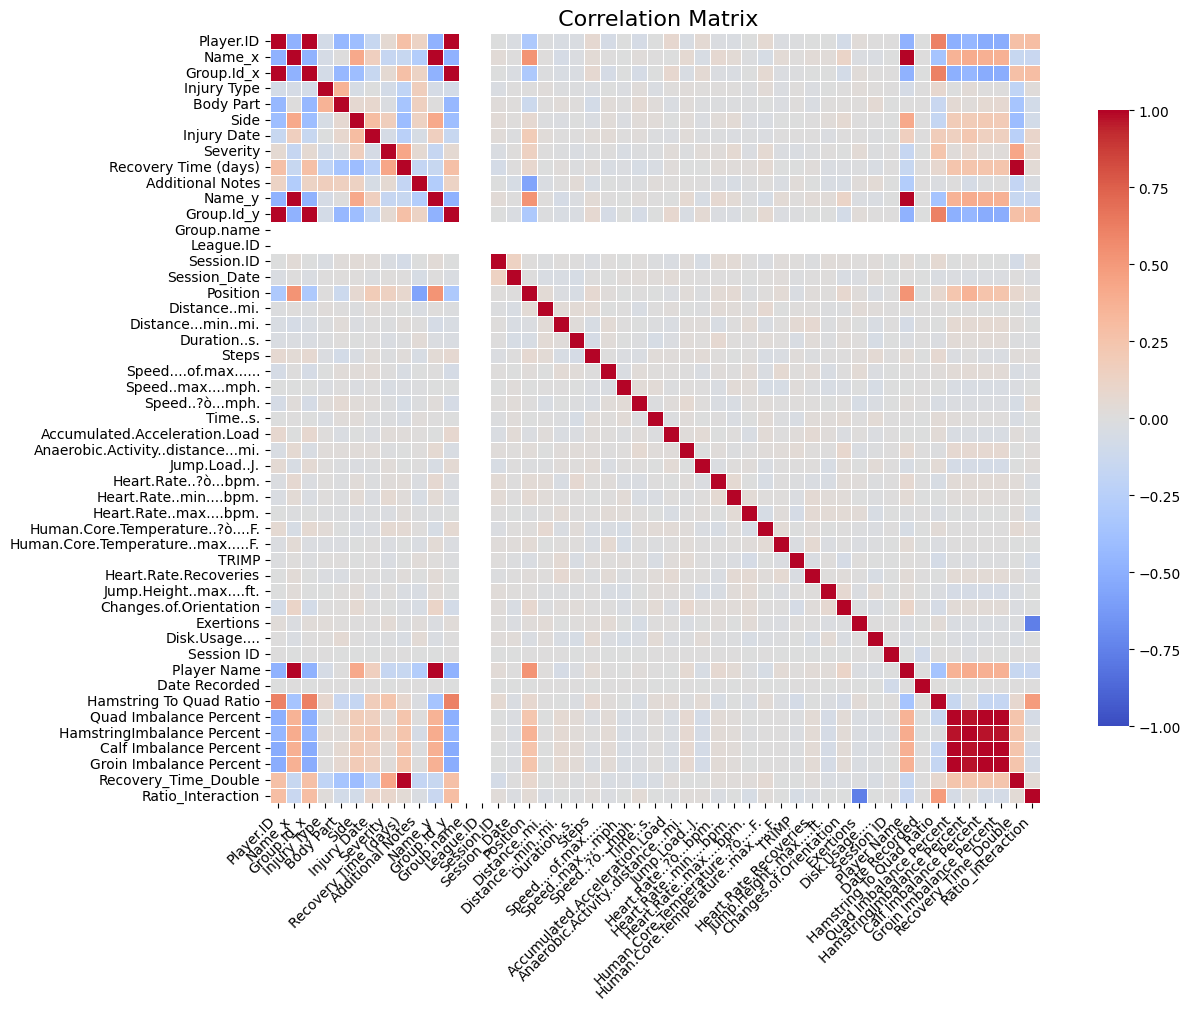

Highly correlated features:
 Player.ID                   Group.Id_x                    1.000000
                            Group.Id_y                    1.000000
Group.Id_x                  Player.ID                     1.000000
Group.Id_y                  Player.ID                     1.000000
Quad Imbalance Percent      HamstringImbalance Percent    0.974564
                            Calf Imbalance Percent        0.999214
                            Groin Imbalance Percent       0.999341
HamstringImbalance Percent  Quad Imbalance Percent        0.974564
                            Calf Imbalance Percent        0.974061
                            Groin Imbalance Percent       0.972437
Calf Imbalance Percent      Quad Imbalance Percent        0.999214
                            HamstringImbalance Percent    0.974061
                            Groin Imbalance Percent       0.999475
Groin Imbalance Percent     Quad Imbalance Percent        0.999341
                            Hamst

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering (Updated Columns)
data['Recovery_Time_Double'] = data['Recovery Time (days)'] * 2  # Example transformation
data['Ratio_Interaction'] = data['Hamstring To Quad Ratio'] / (data['Exertions'] + 1)  # Avoid division by zero

# Correlation Analysis
correlation_matrix = data.corr()

# Improved visualization for better readability
plt.figure(figsize=(15, 10))  # Increase the figure size for better readability
sns.heatmap(
    correlation_matrix,
    annot=False,  # Turn off annotations to reduce clutter; set to True if you want to see values
    cmap='coolwarm',
    vmax=1.0,
    vmin=-1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},  # Adjust colorbar size
)
plt.title(' Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, horizontalalignment='right', fontsize=10)  # Rotate x-axis labels
plt.yticks(fontsize=10)
plt.show()

# Check Multicollinearity
correlation_threshold = 0.9
corr_pairs = correlation_matrix.unstack()
high_corr = corr_pairs[(abs(corr_pairs) > correlation_threshold) & (corr_pairs != 1.0)]
print("Highly correlated features:\n", high_corr)


In [10]:
# Feature Selection and Testing
# Assuming 'Injury Type' is the target column for prediction (adjust if necessary)
X = data.drop(columns=['Injury Type'])  # Replace 'Injury Type' with your actual target column
y = data['Injury Type']  # Replace 'Injury Type' with your actual target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [16]:
# Feature Importance using Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
print(feature_importances)



                                    Importance
Recovery Time (days)                  0.138244
Recovery_Time_Double                  0.129365
Body Part                             0.124360
Injury Date                           0.090424
Additional Notes                      0.085668
Name_y                                0.046969
Severity                              0.046455
Player Name                           0.039157
Side                                  0.032732
Name_x                                0.032589
Group.Id_x                            0.031427
Player.ID                             0.031039
Group.Id_y                            0.030372
Quad Imbalance Percent                0.026637
Calf Imbalance Percent                0.026346
Groin Imbalance Percent               0.025468
HamstringImbalance Percent            0.023364
Hamstring To Quad Ratio               0.022161
Position                              0.013985
Ratio_Interaction                     0.001327
Time..s.     

In [12]:
# Principal Component Analysis (PCA)
pca = PCA(n_components=5)  # Adjust components based on your needs
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)



In [18]:
# Building ML Models
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_pca, y_train)
xgb_pred = xgb_model.predict(X_test_pca)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

# ANN
ann_model = MLPClassifier(random_state=42, max_iter=500)
ann_model.fit(X_train_pca, y_train)
ann_pred = ann_model.predict(X_test_pca)
print("ANN Accuracy:", accuracy_score(y_test, ann_pred))
print(classification_report(y_test, ann_pred))


XGBoost Accuracy: 0.9978813559322034
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1400
           1       1.00      1.00      1.00       572
           2       1.00      1.00      1.00      1041
           3       1.00      1.00      1.00       961
           4       1.00      1.00      1.00       218
           5       1.00      1.00      1.00       516
           6       1.00      1.00      1.00      1017
           7       0.99      1.00      1.00      1137
           8       1.00      1.00      1.00      2106

    accuracy                           1.00      8968
   macro avg       1.00      1.00      1.00      8968
weighted avg       1.00      1.00      1.00      8968

ANN Accuracy: 0.9965432649420161
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1400
           1       1.00      1.00      1.00       572
           2       1.00      1.00      1.00      1041
        